<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/02-pairs.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Pairs Trading

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

### Overview

- Find stock pairs that usually track together
- When the relationship is broken:
  - Buy the stock that is cheap compared to the usual relationship
  - Short sell the stock that is expensive compared to the usual relationship
- Hope the usual relationship is restored soon.

### Model

- $P_1/P_2 \approx \text{constant}$
- When the ratio goes above the constant, it tends to come down.
- When the ratio goes below the constant, it tends to go up.
$$ \Delta P_1/P_2 = \begin{cases}  & + \;\text{when $P_1/P_2 <$ constant}\\
 & - \;\text{when $P_1/P_2 >$ constant}
\end{cases}
$$
-Assume the change is larger when the ratio is further from the constant as
$$\Delta P_1/P_2 = k(\text{constant} - P_1/P_2)$$
for a constant $k>0$.

- The model is equivalent to 
$$\Delta P_1/P_2 = a + bP_1/P_2$$
where $a=k \times \text{constant}$, $b=-k$.
- Estimate $a$ and $b$ by linear regression.
- Should get $a>0$, $b<0$.
- If so, $\text{constant} =-a/b$.
- Hold asset 1 and short 2 when $P_1/P_2 < -a/b - \text{threshold}$.
- Hold asset 2 and short 1 when $P_1/P_2 > -a/b + \text{threshold}$.

In [1]:
import yfinance as yf
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

data = yf.download(["CVX", "COP"], start="2000-01-01")["Adj Close"]
data.index = pd.to_datetime(data.index.strftime("%Y-%m-%d"))
data["ratio"] = data.CVX / data.COP
data["lagged_ratio"] = data.ratio.shift()
data["delta_ratio"] = data.ratio.diff()
regression = smf.ols(
    "delta_ratio ~ lagged_ratio", data
)
a, b = regression.fit().params

[*********************100%***********************]  2 of 2 completed


### Example

- Chevron (CVX) and Conoco-Phillips (COP) from 2000 on
- Adjusted closing prices from Yahoo Finance
- Compute the price ratio: CVX / COP

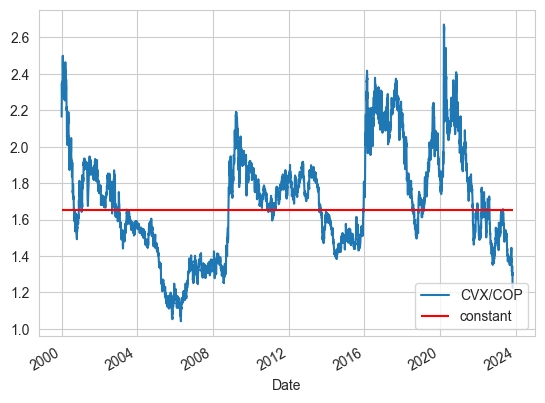

In [2]:
data.ratio.plot(label="CVX/COP")
plt.hlines(
    y=-a/b, 
    xmin = data.index[0], 
    xmax=data.index[-1],
    color="red",
    label="constant"
)
plt.legend(loc="lower right")
plt.show()

### Returns

- $-a/b = 1.66$
- Set threshold = 0.2 as an example
- Buy COP and short CVX when CVX / COP is above $1.86$
- Buy CVX and short COP when CVX / COP is below $1.46$

### Market Neutrality

- The pairs strategy is an example of a market neutral strategy, meaning its market beta should be approximately zero.
- If it has a return above the risk-free rate, then adding some of it to the market portfolio can improve performance relative to holding the market.
- This is the same as saying that the strategy has a positive alpha.
- It is also the same as saying
$$ \text{Sharpe ratio of strategy} > \text{Sharpe ratio of market} \times \text{correlation with market}$$
- Get the market return from Ken French's data library.

In [3]:
threshold = 0.2
data["cvx"] = (
    1 * (data.lagged_ratio < -a/b - threshold)
    - 1 * (data.lagged_ratio > -a/b + threshold)
)
data["cop"] = - data.cvx
data["ret"] = (
    data.cvx*data.CVX.pct_change() + 
    data.cop*data.COP.pct_change()
)

from pandas_datareader import DataReader as pdr
ff = pdr("F-F_Research_Data_Factors_daily", "famafrench", start=2000)[0]
data["mkt"] = ff["Mkt-RF"]


In [4]:
print(f"mean return of pairs strategy = {252*data.ret.mean():.2%} annualized")
print(f"correlation of pairs strategy with market = {data.ret.corr(data.mkt):.2%}")

mean return of pairs strategy = 5.19% annualized
correlation of pairs strategy with market = 4.94%


### Avoid Look-Ahead Bias

- Compute the parameter of the strategy (the constant $-a/b$) from data through 2015
- Test the strategy from 2015 on.

In [5]:
past = data.loc[:"2015-01-01"].copy()
future = data.loc["2015-01-01":].copy() 
regression = smf.ols(
    "delta_ratio ~ lagged_ratio", past
)
a, b = regression.fit().params

In [6]:
threshold = 0.2
future["cvx"] = (
    1 * (future.lagged_ratio < -a/b - threshold)
    - 1 * (future.lagged_ratio > -a/b + threshold)
)
future["cop"] = - future.cvx
future["ret"] = (
    future.cvx*future.CVX.pct_change() + 
    future.cop*future.COP.pct_change()
)

In [7]:
print(f"mean return of pairs strategy = {252*future.ret.mean():.2%} annualized")
print(f"correlation of pairs strategy with market = {future.ret.corr(future.mkt):.2%}")

mean return of pairs strategy = 5.48% annualized
correlation of pairs strategy with market = 10.74%


### Alpha and Beta

- beta = corr with market excess return x std dev of strategy / std dev of market
- alpha = mean return - beta * mean market excess return

In [8]:
beta = future.ret.corr(future.mkt) * future.ret.std() / future.mkt.std()
alpha = future.ret.mean() - beta * future.mkt.mean()

print(f"beta is {beta:.4f}")
print(f"annualized alpha is {252*alpha:.2%}")

beta is 0.0011
annualized alpha is 4.19%


### Regressions in python

- use statsmodels.formula.api
- smf.ols("model", data).fit().summary()

In [9]:
import statsmodels.formula.api as smf
smf.ols("ret~mkt", future).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ret   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     25.15
Date:                Sat, 28 Oct 2023   Prob (F-statistic):           5.75e-07
Time:                        11:42:18   Log-Likelihood:                 6431.3
No. Observations:                2157   AIC:                        -1.286e+04
Df Residuals:                    2155   BIC:                        -1.285e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002      0.000      0.758      0.448      -0.000       0.001
mkt            0.0011      0.000      5.015      0.000       0.001       0.002
==============================================================================
Omnibus:                      438.977   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11512.640
Skew:                           0.267   Prob(JB):                         0.00
Kurtosis:                      14.305   Cond. No.                         1.20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""